In [1]:
import numpy as np
import pandas as pd
import os
import glob
import string
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

## Pre-process Review data

In [2]:
# Get the current working directory
working_dir=os.getcwd()

In [3]:
# Get the positive reviews in a list
path_pos = working_dir+'/train/pos' # use your path
allFiles_pos = glob.glob(path_pos + "/*.txt")
list_final_pos = []
for file in allFiles_pos:
    temp_pos=pd.read_table(file, header=None)
    list_pos=[]
    for r in temp_pos[0]:
        list_pos.append(r)
    list_pos=''.join(list_pos)
    list_final_pos.append(list_pos)  
    
# Get the negative reviews in a list
path_neg = working_dir+'/train/neg' # use your path
allFiles_neg = glob.glob(path_neg + "/*.txt")
list_final_neg = []
for file in allFiles_neg:
    temp_neg=pd.read_table(file, header=None)
    list_neg=[]
    for r in temp_neg[0]:
        list_neg.append(r)
    list_neg=''.join(list_neg)
    list_final_neg.append(list_neg)  

# Combine the lists
list_final = list_final_pos + list_final_neg

In [4]:
# define the labels
labels=[]
for i in range(0,25000):
    if i<12500:
        labels.append(1)
    else:
        labels.append(0)

In [82]:
'''
Clean each document by removing unnecesary characters and splitting by space.
'''
def clean_document(doco):
#     punctuation = string.punctuation + '\n\n';
#     punc_replace = ''.join([' ' for s in punctuation]);
# #     print(punc_replace)
#     doco_clean = doco.replace('-', ' ');
#     doco_alphas = re.sub(r'\W +', '', doco_clean)
#     trans_table = str.maketrans(punctuation, punc_replace);
#     doco_clean = ' '.join([word.translate(trans_table) for word in doco_alphas.split(' ')]);
    doco_clean = doco.split(' ');
    doco_clean = [word.lower() for word in doco_clean if len(word) > 0];
    
    return doco_clean;

review_cleans = [clean_document(doc) for doc in list_final];
sentences = [' '.join(r) for r in review_cleans]

print('Before Cleaning: ', list_final[10])
print('After Cleaning: ', sentences[10])

Before Cleaning:  Aileen Gonsalves, my girlfriend, is in this film playing a secretary at the main character's bank. She has a lovely scene with Roshan Seth in a restaurant. There's more information on her website at >Having stated my personal interest in the film, I have to say that I think it is a beautiful movie - moving, funny and beautifully filmed.
After Cleaning:  aileen gonsalves, my girlfriend, is in this film playing a secretary at the main character's bank. she has a lovely scene with roshan seth in a restaurant. there's more information on her website at >having stated my personal interest in the film, i have to say that i think it is a beautiful movie - moving, funny and beautifully filmed.


In [86]:
# Prepare Tokenizer
t = Tokenizer()
t.fit_on_texts(sentences)
vocab_size = len(t.word_index) + 1
print('Vocabulary Size: ', vocab_size)

# integer encode the documents
encoded_docs = t.texts_to_sequences(sentences)
print('\nText before Sequence Encoding: ', sentences[10])
print('Text after Sequence Encoding: ', encoded_docs[10])

# pad documents to a max length of 4 words
max_length = len(max(encoded_docs))
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post') 
print('\nBefore Padding: ', encoded_docs[10])
print('After Padding: ', padded_docs[10])

Vocabulary Size:  88524

Text before Sequence Encoding:  aileen gonsalves, my girlfriend, is in this film playing a secretary at the main character's bank. she has a lovely scene with roshan seth in a restaurant. there's more information on her website at >having stated my personal interest in the film, i have to say that i think it is a beautiful movie - moving, funny and beautifully filmed.
Text after Sequence Encoding:  [18487, 51994, 58, 976, 6, 8, 11, 19, 393, 3, 3381, 30, 1, 290, 1745, 1974, 57, 45, 3, 1330, 133, 16, 20587, 7798, 8, 3, 3730, 222, 50, 1613, 20, 38, 3893, 30, 257, 3415, 58, 965, 599, 8, 1, 19, 10, 25, 5, 132, 12, 10, 101, 9, 6, 3, 304, 17, 724, 161, 2, 1289, 814]

Before Padding:  [18487, 51994, 58, 976, 6, 8, 11, 19, 393, 3, 3381, 30, 1, 290, 1745, 1974, 57, 45, 3, 1330, 133, 16, 20587, 7798, 8, 3, 3730, 222, 50, 1613, 20, 38, 3893, 30, 257, 3415, 58, 965, 599, 8, 1, 19, 10, 25, 5, 132, 12, 10, 101, 9, 6, 3, 304, 17, 724, 161, 2, 1289, 814]
After Padding:  [18487 

In [6]:
# Use pre-trained Glove word embeddings
embeddings_index = dict()
f = open('glove.6B.300d.txt') 
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [7]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector# create a weight matrix for words in training docs

In [22]:
# Define independent and dependent variables
X = np.array(padded_docs)
y = np.array(labels)
# Split the data into training set and validation set
X_train,X_val,y_train,y_val= train_test_split(X,y,test_size=0.2,random_state=13)

## LSTM- Keras

In [ ]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Embedding
from keras.optimizers import RMSprop, Adam
from keras.layers import LSTM

In [37]:
# define LSTM model
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(LSTM(60))
model.add(Dropout(0.25))
# model.add(Flatten())
model.add(Dense(60, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation = 'sigmoid'))

In [38]:
optimizer = Adam(lr=0.0001)
# compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

In [39]:
# summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 212, 300)          26557200  
_________________________________________________________________
lstm_6 (LSTM)                (None, 60)                86640     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 60)                3660      
_________________________________________________________________
dropout_10 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 61        
Total params: 26,647,561
Trainable params: 90,361
Non-trainable params: 26,557,200
___________________________________________________________

In [40]:
# Train the model
batch_size = 128
epochs = 20
lstm_model = model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, verbose= 1, validation_data=(X_val,y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 68s 3ms/step - loss: 0.6920 - acc: 0.5152 - val_loss: 0.6878 - val_acc: 0.5414
Epoch 2/20
20000/20000 [==============================] - 65s 3ms/step - loss: 0.6838 - acc: 0.5457 - val_loss: 0.6669 - val_acc: 0.5730
Epoch 3/20
20000/20000 [==============================] - 63s 3ms/step - loss: 0.6365 - acc: 0.6517 - val_loss: 0.5753 - val_acc: 0.7510
Epoch 4/20
20000/20000 [==============================] - 64s 3ms/step - loss: 0.5085 - acc: 0.7776 - val_loss: 0.4708 - val_acc: 0.7964
Epoch 5/20
20000/20000 [==============================] - 66s 3ms/step - loss: 0.4552 - acc: 0.8070 - val_loss: 0.4446 - val_acc: 0.8038
Epoch 6/20
20000/20000 [==============================] - 60s 3ms/step - loss: 0.4321 - acc: 0.8153 - val_loss: 0.4200 - val_acc: 0.8204
Epoch 7/20
20000/20000 [==============================] - 61s 3ms/step - loss: 0.4096 - acc: 0.8245 - val_loss: 0.4073 - val_acc:

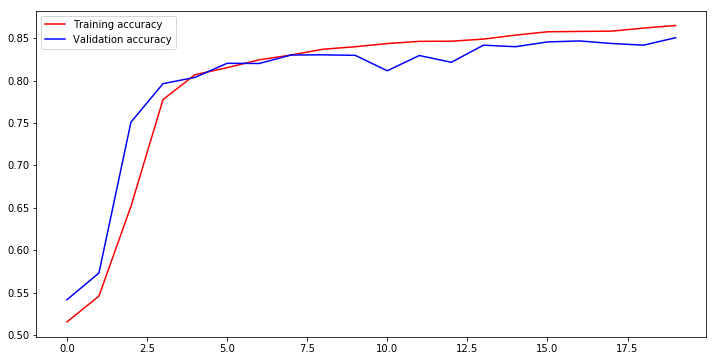

In [41]:
'''
Visualize the Training and Validation accuracies for the given epochs
'''
# Gives a list of accuracies
accuracy= lstm_model.history['acc']
val_accuracy = lstm_model.history['val_acc']
loss = lstm_model.history['loss']
val_loss = lstm_model.history['val_loss']

# Define x-axis
epoch=range(len(accuracy))
# Plot
plt.subplots(figsize=(12, 6))
plt.plot(epoch, accuracy, 'b', label='Training accuracy', color='r')
plt.plot(epoch, val_accuracy, 'b', label='Validation accuracy')
plt.legend()

In [91]:
loss, accuracy = model.evaluate(X_val,y_val)
print('Validation loss: ', loss)
print('Validation Accuracy: ', accuracy)

5000/5000 [==============================] - 9s 2ms/step
Validation loss:  0.34563790402412414
Validation Accuracy:  0.8506


## Test Set Evaluation

In [93]:
# Get the positive reviews in a list
path_pos = working_dir+'/test/pos' # use your path
allFiles_pos = glob.glob(path_pos + "/*.txt")
test_list_final_pos = []
for file in allFiles_pos:
    temp_pos=pd.read_table(file, header=None)
    list_pos=[]
    for r in temp_pos[0]:
        list_pos.append(r)
    list_pos=''.join(list_pos)
    test_list_final_pos.append(list_pos)  
    
# Get the negative reviews in a list
path_neg = working_dir+'/test/neg' # use your path
allFiles_neg = glob.glob(path_neg + "/*.txt")
test_list_final_neg = []
for file in allFiles_neg:
    temp_neg=pd.read_table(file, header=None)
    list_neg=[]
    for r in temp_neg[0]:
        list_neg.append(r)
    list_neg=''.join(list_neg)
    test_list_final_neg.append(list_neg)  

# Combine the lists
test_list_final = test_list_final_pos + test_list_final_neg
print('Number of test examples: ', len(test_list_final) )

Number of test examples:  25000


In [71]:
# Clean the data
test_review_cleans = [clean_document(doc) for doc in test_list_final];
test_sentences = [' '.join(r) for r in test_review_cleans]

# Use the same tokenizer as before
test_encoded_docs = t.texts_to_sequences(test_sentences)

# pad documents to the same max_length
test_padded_docs = pad_sequences(test_encoded_docs, maxlen=max_length, padding='post') 

In [92]:
test_loss, test_accuracy = model.evaluate(test_padded_docs,labels)
print('Test Accuracy: ', test_accuracy)

25000/25000 [==============================] - 45s 2ms/step
Test Accuracy:  0.85476
